# 1. Import required packages

In [1]:
# !pip install tensorflow
# !pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import numpy.random as nr
import random
from datetime import datetime

# folder file use
import glob
import pathlib
import os

# image
import cv2

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

# tensorflow, keras
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras import models, layers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16
from keras.layers import Dropout, Flatten, Dense
from keras.utils.vis_utils import plot_model

# saving history
import pickle

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load images from pokemon folder in local drive

In [3]:
# # unzip zipped file
# from zipfile import ZipFile
# ZipFile("pokemon.zip").extractall()

In [4]:
# List subfolder names in pokemon folder
os.listdir('./pokemon')

['pokemon', 'balbasaur', 'charmander', 'mewtwo', 'pikachu', 'squirtle']

In [5]:
# Identify path to pokemon images
bulbasaur_path = './pokemon/balbasaur'
charmander_path = './pokemon/charmander'
mewtwo_path = './pokemon/mewtwo'
pikachu_path = './pokemon/pikachu'
squirtle_path = './pokemon/squirtle'

pokemon_path = [bulbasaur_path, charmander_path, mewtwo_path, pikachu_path, squirtle_path]

# Determine number of images in each pokemon subfolder as well as the type of image file
# loop through all subfolders in pokemon folder
for path in pokemon_path:
    # count number of images in folder (include both .jpg and .png file extensions)
    print (len([file for file in os.listdir(path) if (file.endswith('jpg') or file.endswith('png'))]), path.split("/")[2] + ' total images: ', 
    str(len([file for file in os.listdir(path) if file.endswith('jpg')])) + ' jpg and ' +str(len([file for file in os.listdir(path) if file.endswith('png')])) + ' png')

50 balbasaur total images:  20 jpg and 30 png
50 charmander total images:  37 jpg and 13 png
50 mewtwo total images:  32 jpg and 18 png
50 pikachu total images:  30 jpg and 20 png
50 squirtle total images:  37 jpg and 13 png


In [6]:
import glob
import pathlib

# Get windows filepath for all image files in all subfolders in pokemon
poke_path = pathlib.Path('./pokemon')

# check the total number of jpg files in pokemon folder
data_jpg = list(poke_path.glob("*/*.jpg"))
print (len(data_jpg), 'number of jpg files')

# check the total number of png files in pokemon folder
data_png = list(poke_path.glob("*/*.png"))
print (len(data_png), 'number of png files')

# check total number of image files (jpg + png) in pokemon folder
# coombine two lists, then sort
data_path = data_jpg + data_png
data_path.sort()
print (len(data_path), 'number of image files')

# print out first 5 elements to check, should contain relative folder path + filename
print (data_path[:5])

156 number of jpg files
94 number of png files
250 number of image files
[PosixPath('pokemon/balbasaur/00000069.png'), PosixPath('pokemon/balbasaur/00000070.png'), PosixPath('pokemon/balbasaur/00000072.png'), PosixPath('pokemon/balbasaur/00000075.png'), PosixPath('pokemon/balbasaur/00000076.png')]


In [7]:
import cv2

# Create pokemon label dictionary
poke_labels_dict = {
    'balbasaur': 0,
    'charmander': 1,
    'mewtwo': 2,
    'pikachu': 3,
    'squirtle': 4
}

print (poke_labels_dict)
print ("\n")

# Create pokemon folder dictionary to store all pokemon filename (including extensions) in their respective subdirectories
poke_images_dict =  {
    'balbasaur': list(poke_path.glob("balbasaur/*")),
    'charmander': list(poke_path.glob("charmander/*")),
    'mewtwo': list(poke_path.glob("mewtwo/*")),
    'pikachu': list(poke_path.glob("pikachu/*")),
    'squirtle': list(poke_path.glob("squirtle/*")),
}
# print out 1st filename in each poke folder and the shape of the file to check
for poke in poke_images_dict:
    print (poke_images_dict[poke][0], '\t', cv2.imread(str(poke_images_dict[poke][0])).shape)

{'balbasaur': 0, 'charmander': 1, 'mewtwo': 2, 'pikachu': 3, 'squirtle': 4}


pokemon/balbasaur/00000069.png 	 (1536, 1024, 3)
pokemon/charmander/00000045.png 	 (881, 1174, 3)
pokemon/mewtwo/00000194.jpg 	 (1200, 1920, 3)
pokemon/pikachu/00000186.png 	 (1200, 1000, 3)
pokemon/squirtle/00000179.png 	 (600, 900, 3)


# 3. Preparing Data

In [8]:
# specify image dimensions for resizing
img_resize_dim = (224, 224)

# resize all image files by using for loop below
raw_images = []
resized_images = []
labels = []

# iterate through all image filenames in dictionary 
for poke, imgs in poke_images_dict.items():
    # iterate through each image file
    for img in imgs:
        # open each image file
        image = cv2.imread(str(img))
        # append each raw image file to list 'raw_images'
        raw_images.append(image)
        # resize every image to 224 by 224 in order to fit VGG16 model later
        resized_image = cv2.resize(image, img_resize_dim)
        # append each resized image file to resized_images to form a list (3 dimensionary array)
        resized_images.append(resized_image)
        # append the corresponding class label (dictionary value) to labels to form a list
        labels.append(poke_labels_dict[poke])


# Convert images from list to numpy array
raw_images = np.array(raw_images)
resized_images = np.array(resized_images)


# Convert labels from list to numpy array
labels = np.array(labels)
# # convert array to list of lists array with dtype = uint8
labels = np.array([[elem] for elem in labels], dtype=np.uint8)

# check
print ("Data Shape")
print ('Raw image: ', raw_images.shape)
print ('Resized image: ', resized_images.shape)
print ('Labels: ', labels.shape)


Data Shape
Raw image:  (250,)
Resized image:  (250, 224, 224, 3)
Labels:  (250, 1)


/tmp/ipykernel_1167/653171997.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  raw_images = np.array(raw_images)


# 4. Do train test split

In [9]:
from sklearn.model_selection import train_test_split

# fix random seed for reproducibility
nr.seed(42)

# Create train (60%), validation (20%) and test set (20%), with equal number of class labels in each set
# Carry out train test split using scikit learn with 20% (n=50) as test se
train_images, test_images, train_labels, test_labels = train_test_split(resized_images, labels, test_size=0.2, stratify=labels, shuffle=True, random_state=42)
# From train set (80%), split into training and validation set (25%)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, stratify=train_labels, shuffle=True, random_state=42)

print("Train images shape: {}".format(train_images.shape))
print("Train labels shape: {}".format(train_labels.shape))
print("Validation images shape: {}".format(val_images.shape))
print("Validation labels shape: {}".format(val_labels.shape))
print("Test images shape: {}".format(test_images.shape))
print("Test labels shape: {}".format(test_labels.shape))
print ("\n")

# print and show the label distribution in order to make sure it's even
unique_train, counts_train = np.unique(train_labels, return_counts=True)
unique_val, counts_val = np.unique(val_labels, return_counts=True)
unique_test, counts_test = np.unique(test_labels, return_counts=True)

print ("Train labels distribution: ", '\n', np.asarray((unique_train, counts_train)).T)
print ("Validation labels distribution: ", '\n', np.asarray((unique_val, counts_val)).T)
print ("Test labels distribution: ", '\n', np.asarray((unique_test, counts_test)).T)


Train images shape: (150, 224, 224, 3)
Train labels shape: (150, 1)
Validation images shape: (50, 224, 224, 3)
Validation labels shape: (50, 1)
Test images shape: (50, 224, 224, 3)
Test labels shape: (50, 1)


Train labels distribution:  
 [[ 0 30]
 [ 1 30]
 [ 2 30]
 [ 3 30]
 [ 4 30]]
Validation labels distribution:  
 [[ 0 10]
 [ 1 10]
 [ 2 10]
 [ 3 10]
 [ 4 10]]
Test labels distribution:  
 [[ 0 10]
 [ 1 10]
 [ 2 10]
 [ 3 10]
 [ 4 10]]


# 4.1 Display some images from training set

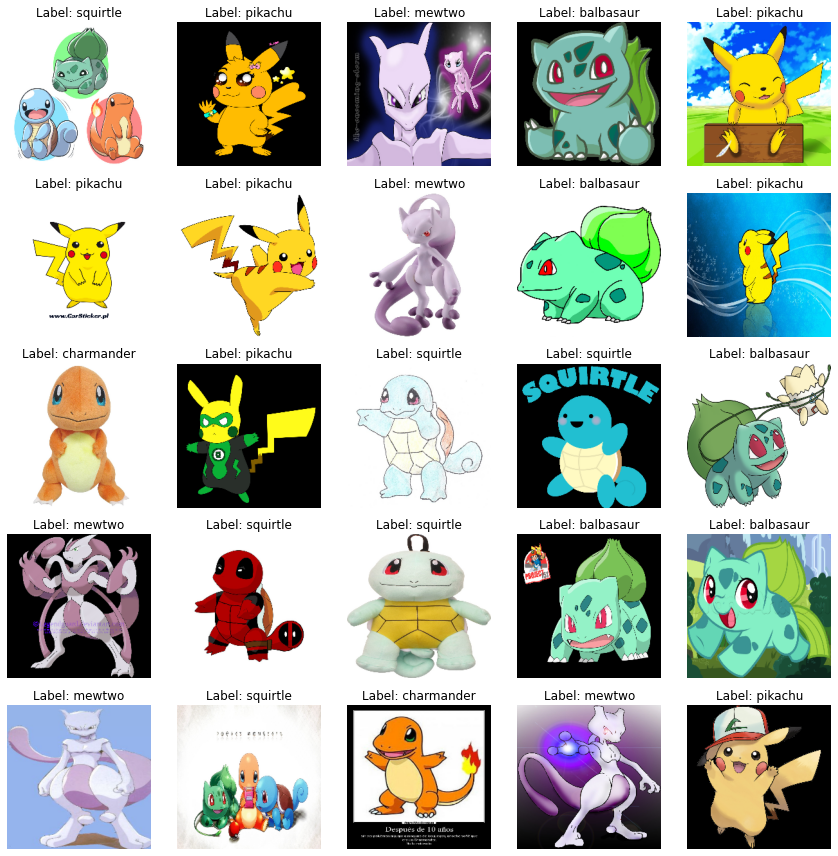

In [10]:
import matplotlib.pyplot as plt

# To create a mapping of the label class to allow display of the description instead of a number
# Create a list from dictionary keys
categories = list(poke_labels_dict.keys())

# configure size of display window
plt.figure(figsize=(12, 12))
# show 25 images
for i in range(0, 25):
    # images arranged in 5 rows and 5 columns and i refers to position position of each image/subplot.
    plt.subplot(5, 5, i+1)
    # convert image from BGR to RGB
    plt.imshow(cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB))
    # turn off axis of each image plot
    plt.axis('off')
    # show image classification on top of image
    plt.title('Label: {}'.format(categories[train_labels[i][0]]))

plt.tight_layout()
plt.show()

# 4.2 Process the data
* Normalize the images of all datasets
* One-hot encoding on all labels

In [11]:
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

# Normalize the data
train_images_norm = train_images.astype('float32')/255
val_images_norm = val_images.astype('float32')/255
test_images_norm = test_images.astype('float32')/255

# One-hot encoding on the labels (convert to one-hot vector)
train_labels_cat = to_categorical(train_labels)
val_labels_cat = to_categorical(val_labels)
test_labels_cat = to_categorical(test_labels)

# 5. Transfer learning using VGG16

## 5.1 Using the base Pre-trained Network (VGG16) without additional training
VGG16 is a CNN architecture which was used to win the ILSVR competition in 2014. What the competition aims to achieve is to train a model that can correctly classify an input image into 1,000 separate object categories.

The VGG network architecture is characterized by its simplicity of using only 3x3 convolution layers stacked on top of each other in increasing depth. It using Max-Pooling to reduce the volume size and completes with a 2 fully-connected layer, each with 4,096 nodes, followed by a softmax classifier.

VGG16 and VGG19 refers to the numbers of weighted layers in the network. 

## 5.2 Loading the VGG16 Pre-trained model without top classification layer

The first time a pre-trained model is loaded, Keras will download the required model weights. By default, the model expects color input images to be rescaled to the size of 224x224, minimum is 48x48. Lets load the model using Keras.

Note: For more details on Keras implementation of the pre-trained model, you can refer to https://keras.io/api/applications/

* Prepare a custom classifier
* Stack both models on top of each other

In [12]:
from keras import Model
from keras.applications import vgg16
from keras.layers import Dropout, Flatten, Dense
from keras.utils.vis_utils import plot_model

# importing VGG16 from keras with pre-trained weights that is trained on imagenet
# include_top > False to exclude the top classification layer  (exclude FC1000)
# weights > to use the weights from pre-training on Imagenet
vgg16model = vgg16.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(224, 224, 3))

# print out summary of VGG model
vgg16model.summary()

# plot out model visualisation of all layers
tf.keras.utils.plot_model(vgg16model, show_shapes=True)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# print all layers in the network architecture
for i, layer in enumerate(vgg16model.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))

Layer 0: input_1 (True)
Layer 1: block1_conv1 (True)
Layer 2: block1_conv2 (True)
Layer 3: block1_pool (True)
Layer 4: block2_conv1 (True)
Layer 5: block2_conv2 (True)
Layer 6: block2_pool (True)
Layer 7: block3_conv1 (True)
Layer 8: block3_conv2 (True)
Layer 9: block3_conv3 (True)
Layer 10: block3_pool (True)
Layer 11: block4_conv1 (True)
Layer 12: block4_conv2 (True)
Layer 13: block4_conv3 (True)
Layer 14: block4_pool (True)
Layer 15: block5_conv1 (True)
Layer 16: block5_conv2 (True)
Layer 17: block5_conv3 (True)
Layer 18: block5_pool (True)


## 5.3 "Freeze" base layers of VGG16 
Once we preload the VGG16 model, we can choose to freeze the "deep layers" of the model and only re-train the last few layers on our own data. This is common transfer learning strategy and is often a good approach when the amount of training data is limited. 

In [14]:
# freeze base layers of VGG16
for layer in vgg16model.layers:
     layer.trainable = False

## 5.4 Build classification layers 
* to be added on top of the VGG16 pre-trained model

In [15]:
%%time
from keras import models

#creating own layers in addition to VGG16 as the base layers
model = models.Sequential(vgg16model.layers)

# HINT: after CNN layers, we need to flatten and create our fully connected layers and final output laters for classifications
# determine with you own estimation on the layers and nodes for your network. 
# it does not need to be perfect, an estimation will work for a start

# Layers added
model.add(Flatten())
# Uncomment the following dense layer to your preference of accuracy
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
model.add(Dense(len(pokemon_path), activation='softmax'))

print(model.summary())

# plot out model visualisation of all layers
tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [16]:
# print all layers and which ones that are trainable
for i, layer in enumerate(model.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))

Layer 0: block1_conv1 (False)
Layer 1: block1_conv2 (False)
Layer 2: block1_pool (False)
Layer 3: block2_conv1 (False)
Layer 4: block2_conv2 (False)
Layer 5: block2_pool (False)
Layer 6: block3_conv1 (False)
Layer 7: block3_conv2 (False)
Layer 8: block3_conv3 (False)
Layer 9: block3_pool (False)
Layer 10: block4_conv1 (False)
Layer 11: block4_conv2 (False)
Layer 12: block4_conv3 (False)
Layer 13: block4_pool (False)
Layer 14: block5_conv1 (False)
Layer 15: block5_conv2 (False)
Layer 16: block5_conv3 (False)
Layer 17: block5_pool (False)
Layer 18: flatten (True)
Layer 19: dense (True)
Layer 20: dropout (True)
Layer 21: dense_1 (True)


## 5.5 Initialize ImageDataGenerator to augment images 

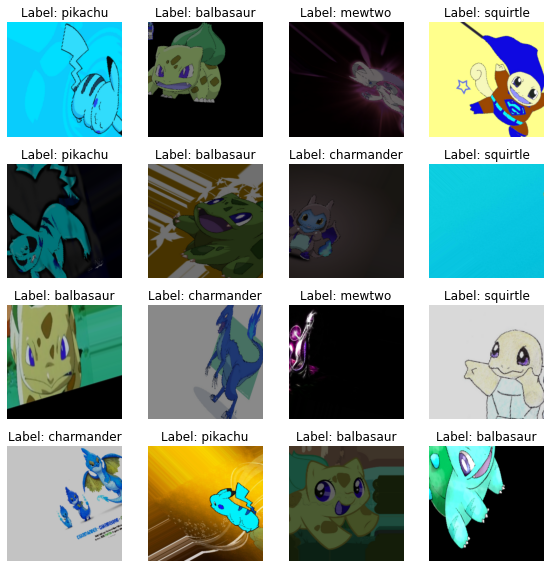

In [17]:
# Initialize the ImageDataGenerator to augment images, to be used for training set later
datagen = ImageDataGenerator(rescale=1./255, # normalize training images during CNN training
                             rotation_range=45, # value in degrees (0 - 180)
                             width_shift_range=[int(-0.25*img_resize_dim[0]), int(0.25*img_resize_dim[1])],
                             height_shift_range=0.25, # used 25% range of image resolution size 224 by 224 
                             shear_range=0.2,  
                             zoom_range=0.3, # [1-zoom_range,1+zoom_range]
                             horizontal_flip=True,
                             vertical_flip=False, # no vertical flip
                             brightness_range=[0.2, 1.2],
                            )

# Look at the image generator and fine tune the parameters above
for batch_x, batch_y in datagen.flow(train_images_norm, train_labels_cat, batch_size=16): 
    plt.figure(figsize=(8, 8))
    for i in range(16):
        x = batch_x[i]
        y = batch_y[i]
        index = np.argmax(y)
        plt.subplot(4, 4, i+1)
        plt.imshow(x)
        plt.axis('off')
        plt.title('Label: {}'.format(categories[index]))
    plt.tight_layout()
    plt.show()
    break

# Fits the data generator to some sample data.
# This computes the internal data stats related to the data-dependent transformations, based on an array of sample data.
# datagen.fit(train_images_norm)

## 5.6 Perform training on dataset by using the "transferred" VGG16 model + custom layers
* Larger batch sizes
    * result in faster progress in training (faster the model per epoch during training), but don't always converge as fast.
    * decreases the quality of the model (lower ability to generalize)
* Smaller batch sizes 
    * train slower, but can converge faster

In [18]:
# fix random seed for reproducibility
nr.seed(42)
# Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(42)

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# initilize a stopper to the training process once the metric val_loss does not improve any further.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# set filename for saving best model
filepath = "model_base_best.h5"

# set up a checkpoint to save Keras model or model weights once minimum loss is reached 
ckpt = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

# Begin model training
initial_epochs=30
batchs = 4
# during training of network, datagen.flow will fit augmentation to training images
# no augmentation will be done to validation set
# steps_per_epoch is set so that for every epoch, each training sample is augmented only one time.
history_base = model.fit(datagen.flow(train_images_norm, train_labels_cat, batch_size=batchs, shuffle=True), 
                      validation_data=(val_images_norm, val_labels_cat),
                    callbacks=[ckpt], steps_per_epoch=len(train_images_norm) // batchs, epochs=initial_epochs, verbose=1)

test_loss, test_acc = model.evaluate(test_images_norm, test_labels_cat, verbose=1)
print('Test loss: {:.4f}'.format(test_loss))
print('Test accuracy: {:.4f}'.format(test_acc))

Epoch 1/30
36/37 [============================>.] - ETA: 0s - loss: 12.7314 - accuracy: 0.2606
Epoch 1: val_accuracy improved from -inf to 0.36000, saving model to model_base_best.h5
37/37 [==============================] - 15s 329ms/step - loss: 12.5239 - accuracy: 0.2534 - val_loss: 5.0488 - val_accuracy: 0.3600
Epoch 2/30
36/37 [============================>.] - ETA: 0s - loss: 4.1743 - accuracy: 0.4437
Epoch 2: val_accuracy improved from 0.36000 to 0.50000, saving model to model_base_best.h5
37/37 [==============================] - 7s 193ms/step - loss: 4.0937 - accuracy: 0.4452 - val_loss: 2.7592 - val_accuracy: 0.5000
Epoch 3/30
37/37 [==============================] - ETA: 0s - loss: 5.3817 - accuracy: 0.3493
Epoch 3: val_accuracy did not improve from 0.50000
37/37 [==============================] - 2s 52ms/step - loss: 5.3817 - accuracy: 0.3493 - val_loss: 2.4024 - val_accuracy: 0.4400
Epoch 4/30
37/37 [==============================] - ETA: 0s - loss: 2.5717 - accuracy: 0.4726

In [19]:
# Save model
model.save(f"model_base.h5")

In [20]:
from datetime import datetime
# datetime object containing current date and time
now = datetime.now().strftime("%d%m%Y_%H%M%S")

# Save or Retrive history
import pickle
# save history
f = open(f'history_base_{now}.pckl', 'wb')
pickle.dump(history_base.history, f)
f.close()

# retrieve:    
# f = open('history_base_{now}.pckl', 'rb')
# history_load = pickle.load(f)
# f.close()

## 5.7. Evaluate the "transferred" and "re-trained" model

In [21]:
# Load best model saved earlier
model_base_best = tf.keras.models.load_model('model_base_best.h5', custom_objects=None, compile=True, options=None)

# evaluate model on test
test_loss_ftune, test_acc_ftune = model_base_best.evaluate(test_images_norm, test_labels_cat, verbose=1)
print('Test loss: {:.4f}'.format(test_loss_ftune))
print('Test accuracy: {:.4f}'.format(test_acc_ftune))

2/2 [==============================] - 0s 125ms/step - loss: 0.9687 - accuracy: 0.7200
Test loss: 0.9687
Test accuracy: 0.7200


### 5.7.1 Plot loss curve and accuracy curve graphs

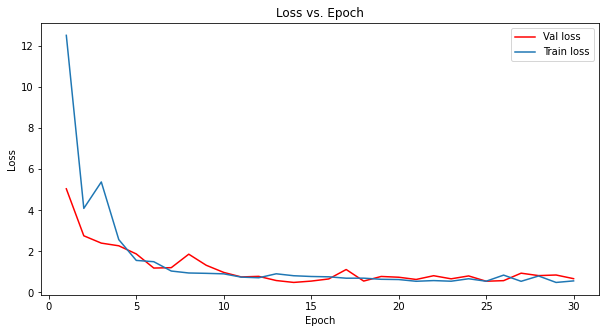

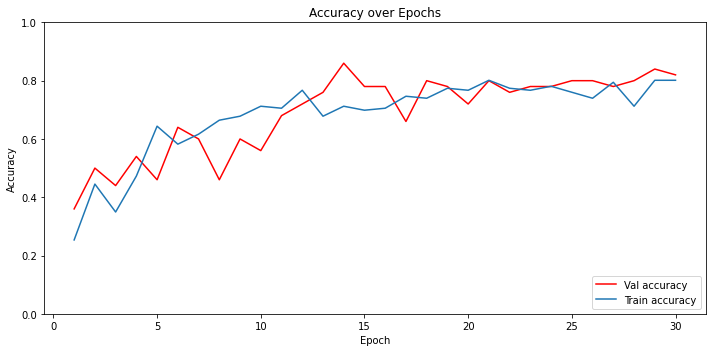

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt


# Plot the loss curve graph
def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = list(range(1, len(val_loss) + 1))
    plt.figure(figsize=(10, 5))
    plt.plot(x, val_loss, color='red', label='Val loss')
    plt.plot(x, train_loss, label='Train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.xlim([0, initial_epochs])
    # plt.ylim([0, 1])
    plt.title('Loss vs. Epoch')
    plt.legend(loc ='upper right')

# Plot the accuracy curve graph
def plot_accuracy(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    x = list(range(1, len(val_acc) + 1))
    plt.figure(figsize=(10, 5))
    plt.plot(x, val_acc, color='red', label='Val accuracy')
    plt.plot(x, train_acc, label='Train accuracy')  
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.xlim([0, initial_epochs])
    plt.ylim([0, 1.0])
    plt.title('Accuracy over Epochs')  
    plt.legend(loc='lower right')

# Plot both graphs
plot_loss(history_base)
plot_accuracy(history_base)
plt.tight_layout()

Observations:
* As the graphs showed low bias and low variance, the model does not seem to show overfitting
* Nevertheless, we'll conduct fine-tuning adjustments to the model in hopes of raising the accuracy levels on test data.

### 5.7.2 Classification Metrics

In [23]:
# Show the classification metrics of base model that has lowest validation loss
from sklearn import metrics

# Create prediction data in order to be used in classification metrics
base_prob = model_base_best.predict(test_images_norm)
base_preds = np.round(model_base_best.predict(test_images_norm),0)

# Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
# Basically, flipping a dummy variable back to it’s categorical variable
y_test = pd.DataFrame(test_labels_cat).idxmax(axis=1)
y_base_pred = np.argmax(base_preds, axis=1)

# Classes variable is same as categories, intended to show the labels in the classification metrics report
classes = list(poke_labels_dict.keys())

# Show the classification metrics
classification_metrics_base = metrics.classification_report(test_labels_cat, base_preds, target_names=classes)
print
print (classification_metrics_base)

              precision    recall  f1-score   support

   balbasaur       0.89      0.80      0.84        10
  charmander       1.00      0.50      0.67        10
      mewtwo       0.89      0.80      0.84        10
     pikachu       0.86      0.60      0.71        10
    squirtle       0.47      0.80      0.59        10

   micro avg       0.74      0.70      0.72        50
   macro avg       0.82      0.70      0.73        50
weighted avg       0.82      0.70      0.73        50
 samples avg       0.70      0.70      0.70        50



/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Base model's ROC-AUC score =  0.92


ROC-AUC score of balbasaur = 0.97
ROC-AUC score of charmander = 0.86
ROC-AUC score of mewtwo = 0.9
ROC-AUC score of pikachu = 0.96
ROC-AUC score of squirtle = 0.89




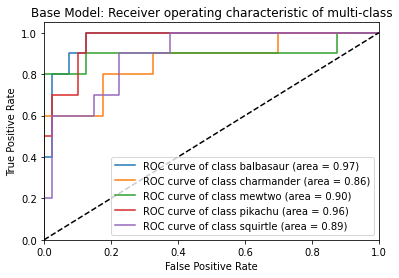

In [24]:
### 5.7.3. ROC-AUC
from sklearn.metrics import roc_curve, roc_auc_score, auc

#roc auc score
roc_auc_base = roc_auc_score(y_test, base_prob, multi_class='ovo', average='weighted')
print ("Base model's ROC-AUC score = ", np.round(roc_auc_base,2))
print ("\n")

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_cat[:, i], base_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print ('ROC-AUC score of', classes[i], '=', np.round(roc_auc[i],2))

print ("\n")

# Plot ROC curve
plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Base Model: Receiver operating characteristic of multi-class')
plt.legend(loc="lower right")
plt.show()

### 5.7.3 Confusion Matrix

Confusion matrix: 
 [[8 0 0 0 2]
 [0 5 1 0 4]
 [1 0 8 0 1]
 [2 0 0 6 2]
 [1 0 0 1 8]]


Confusion Matrix in dataframe form: 
             balbasaur  charmander  mewtwo  pikachu  squirtle
balbasaur           8           0       0        0         2
charmander          0           5       1        0         4
mewtwo              1           0       8        0         1
pikachu             2           0       0        6         2
squirtle            1           0       0        1         8


Confusion Matrix in visualised form: 



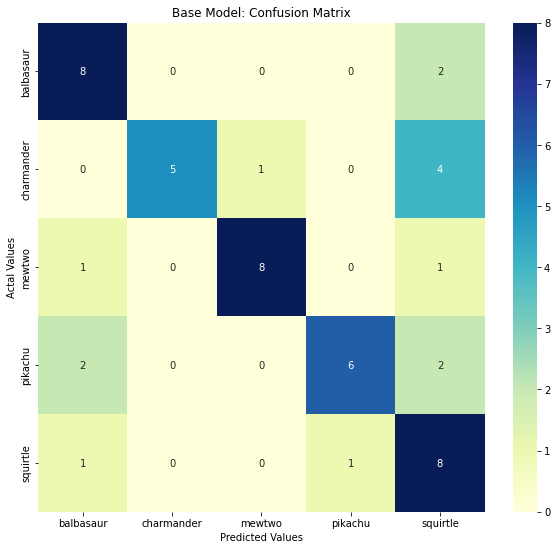

In [25]:
from sklearn.metrics import confusion_matrix

cm_base = confusion_matrix(y_test, y_base_pred)

print('Confusion matrix: \n',cm_base)
print ("\n")

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_base_df = pd.DataFrame(cm_base,
                     index = classes, 
                     columns = classes)

print ("Confusion Matrix in dataframe form: \n", cm_base_df)
print ("\n")

print ("Confusion Matrix in visualised form: \n")
import seaborn as sns
# Plotting the confusion matrix
plt.figure(figsize=(10,9))
sns.heatmap(cm_base_df, annot=True, cmap='YlGnBu')
plt.title('Base Model: Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


# 6. Fine tuning
* Key understanding:
    * First few layers basically learn simply and generic features that generalize to almost all types of images. 
    * Higher top layers in most convolutional networks are more specialized, meaning that features are increasingly more specific to the dataset on the model being trained.


* Currently, training was done only to a few layers on top of the VGG16 base model, which meant that the weights of the pre-trained network model VGG16 were not updated during training.
* At this stage, we can increase the performance of the model by training ('fine-tuning') the weights of the top layers of the pre-trained VGG16 base model alongside the training of the classifier added (5 labels of pokemon). 
* This fine-tuning process will then force the weights to be tuned from generic feature maps to features associated specifically with the dataset.
* As such, the goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.
* Speciifcally, fine-tune a small number of top layers in VGG16 pre-trained model.

## 6.1 Un-freeze the top layers of the model
* 1. set the bottom layers to be un-trainable
* 2. then recompile the model (necessary for these changes to take effect), and resume training.

In [26]:
# set bottom layers of VGG16 pre-trained model to be un-trainable
vgg16model.trainable = True

# print number of layers in pre-trained VGG16 model
print ("Number of layers = ", len(vgg16model.layers))

# print out model summary to observe how many layers
vgg16model.summary()

# print all layers and which ones that are trainable
for i, layer in enumerate(vgg16model.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))

Number of layers =  19
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56

In [27]:
# Start by fine-tuning from which layer
fine_tune_at = 14+1

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16model.layers[:fine_tune_at]:
    layer.trainable = False
    
# print all layers and which ones that are trainable in the model which was used (including additional layers)
for i, layer in enumerate(model.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))

Layer 0: block1_conv1 (False)
Layer 1: block1_conv2 (False)
Layer 2: block1_pool (False)
Layer 3: block2_conv1 (False)
Layer 4: block2_conv2 (False)
Layer 5: block2_pool (False)
Layer 6: block3_conv1 (False)
Layer 7: block3_conv2 (False)
Layer 8: block3_conv3 (False)
Layer 9: block3_pool (False)
Layer 10: block4_conv1 (False)
Layer 11: block4_conv2 (False)
Layer 12: block4_conv3 (False)
Layer 13: block4_pool (False)
Layer 14: block5_conv1 (True)
Layer 15: block5_conv2 (True)
Layer 16: block5_conv3 (True)
Layer 17: block5_pool (True)
Layer 18: flatten (True)
Layer 19: dense (True)
Layer 20: dropout (True)
Layer 21: dense_1 (True)


## 6.2 Re-compile model with lower learning rate
* To avoid model overfitting, lower learning rate is used during 'compile model' so that pretrained weights can readapt to the much larger model 

In [28]:
# re-compile model
# fix random seed for reproducibility
nr.seed(42)
# Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(42)

# Initialize Adam optimizer (gradient descent) with default values except for learning rate which is divided by 10 now  
opt = tf.keras.optimizers.Adam(learning_rate=0.001/10, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# Compile model
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# setting up early stopping, model checkpoint to save best model while model is training
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# initilize a stopper to the training process once the metric val_loss does not improve any further.
es_ftune = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# set filename for saving best model
filepath_ftune = "model_finetune_best.h5"

# set up a checkpoint to save Keras model or model weights once minimum loss is reached 
ckpt_ftune = ModelCheckpoint(filepath_ftune, monitor='val_accuracy', verbose=1, save_best_only=True)


# train model by fitting
# here we increase number of epochs by 10
num_epochs_ftune=initial_epochs+10

# during training of network, datagen.flow will flow in data, no image augmentation is done to validation set 
# steps_per_epoch is set so that for every epoch, each training sample is augmented only one time.
history_finetune = model.fit(datagen.flow(train_images_norm, train_labels_cat, batch_size=batchs, shuffle=True), 
                      validation_data=(val_images_norm, val_labels_cat),
                    callbacks=[ckpt_ftune], steps_per_epoch=len(train_images_norm) // batchs, epochs=num_epochs_ftune, verbose=1)

test_loss_ftune, test_acc_ftune = model.evaluate(test_images_norm, test_labels_cat, verbose=1)
print('Test loss: {:.4f}'.format(test_loss_ftune))
print('Test accuracy: {:.4f}'.format(test_acc_ftune))


Epoch 1/40
37/37 [==============================] - ETA: 0s - loss: 1.2776 - accuracy: 0.5753
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to model_finetune_best.h5
37/37 [==============================] - 9s 216ms/step - loss: 1.2776 - accuracy: 0.5753 - val_loss: 2.2287 - val_accuracy: 0.6000
Epoch 2/40
36/37 [============================>.] - ETA: 0s - loss: 1.0253 - accuracy: 0.6408
Epoch 2: val_accuracy improved from 0.60000 to 0.82000, saving model to model_finetune_best.h5
37/37 [==============================] - 8s 209ms/step - loss: 1.0047 - accuracy: 0.6507 - val_loss: 0.8020 - val_accuracy: 0.8200
Epoch 3/40
36/37 [============================>.] - ETA: 0s - loss: 0.5145 - accuracy: 0.8239
Epoch 3: val_accuracy did not improve from 0.82000
37/37 [==============================] - 2s 54ms/step - loss: 0.5146 - accuracy: 0.8219 - val_loss: 0.9114 - val_accuracy: 0.7800
Epoch 4/40
36/37 [============================>.] - ETA: 0s - loss: 0.6462 - accuracy: 0

In [29]:
# Save model
model.save(f"model_finetune.h5")

In [30]:
from datetime import datetime
# datetime object containing current date and time
now = datetime.now().strftime("%d%m%Y_%H%M%S")

# Save or Retrive history
import pickle

# save history
f = open(f'history_finetune_{now}.pckl', 'wb')
pickle.dump(history_finetune.history, f)
f.close()

## 6.3 Evaluate the fine-tuned model

In [31]:
# Load best model saved earlier
model_finetune_best = tf.keras.models.load_model('model_finetune_best.h5', custom_objects=None, compile=True, options=None)

# evaluate model on test
test_loss_ftune, test_acc_ftune = model_finetune_best.evaluate(test_images_norm, test_labels_cat, verbose=1)
print('Test loss: {:.4f}'.format(test_loss_ftune))
print('Test accuracy: {:.4f}'.format(test_acc_ftune))

2/2 [==============================] - 1s 136ms/step - loss: 0.8001 - accuracy: 0.8800
Test loss: 0.8001
Test accuracy: 0.8800


### 6.3.1 Plot loss curve and accuracy curve graphs

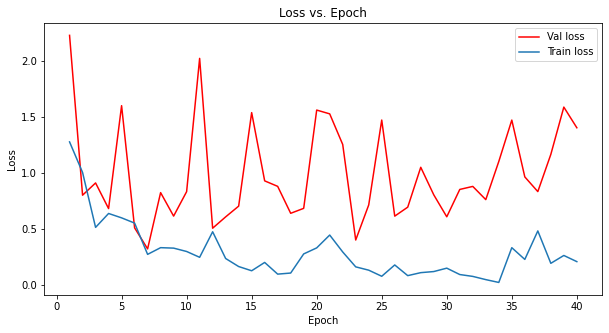

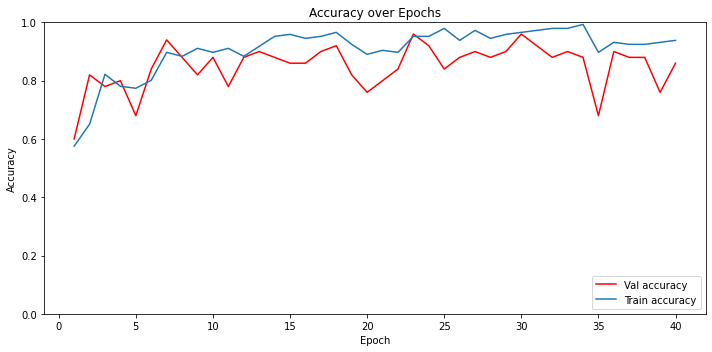

In [32]:
%matplotlib inline

# Plot both graphs
plot_loss(history_finetune)
plot_accuracy(history_finetune)
plt.tight_layout()


### 6.3.2 Classification Metrics

In [33]:
# Show the classification metrics of fine-tuned model with lowest validation loss
from sklearn import metrics

# Create prediction data in order to be used in classification metrics
ftune_prob = model_finetune_best.predict(test_images_norm)
ftune_preds = np.round(model_finetune_best.predict(test_images_norm),0)

# Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
# Basically, flipping a dummy variable back to it’s categorical variable
y_test = pd.DataFrame(test_labels_cat).idxmax(axis=1)
y_ftune_pred = np.argmax(ftune_preds, axis=1)

# Classes variable is same as categories, intended to show the labels in the classification metrics report
classes = list(poke_labels_dict.keys())

# Show the classification metrics
classification_metrics_ftune = metrics.classification_report(test_labels_cat, ftune_preds, target_names=classes)
print
print (classification_metrics_ftune)

              precision    recall  f1-score   support

   balbasaur       0.91      1.00      0.95        10
  charmander       0.73      0.80      0.76        10
      mewtwo       1.00      0.90      0.95        10
     pikachu       1.00      0.90      0.95        10
    squirtle       0.80      0.80      0.80        10

   micro avg       0.88      0.88      0.88        50
   macro avg       0.89      0.88      0.88        50
weighted avg       0.89      0.88      0.88        50
 samples avg       0.88      0.88      0.88        50



### 6.3.3 ROC-AUC

Fine tuned model's ROC-AUC score =  0.97


ROC-AUC score of balbasaur = 1.0
ROC-AUC score of charmander = 0.93
ROC-AUC score of mewtwo = 0.98
ROC-AUC score of pikachu = 0.99
ROC-AUC score of squirtle = 0.96




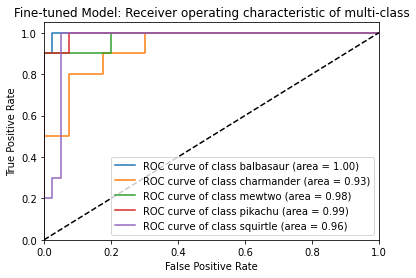

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

#roc auc score
roc_auc_ftune = roc_auc_score(y_test, ftune_prob, multi_class='ovo', average='weighted')
print ("Fine tuned model's ROC-AUC score = ", np.round(roc_auc_ftune,2))
print ("\n")

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_cat[:, i], ftune_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print ('ROC-AUC score of', classes[i], '=', np.round(roc_auc[i],2))

print ("\n")

# Plot ROC curve
plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fine-tuned Model: Receiver operating characteristic of multi-class')
plt.legend(loc="lower right")
plt.show()

### 6.3.4 Confusion Matrix

Confusion matrix: 
 [[10  0  0  0  0]
 [ 0  8  0  0  2]
 [ 1  0  9  0  0]
 [ 0  1  0  9  0]
 [ 0  2  0  0  8]]


Confusion Matrix in dataframe form: 
             balbasaur  charmander  mewtwo  pikachu  squirtle
balbasaur          10           0       0        0         0
charmander          0           8       0        0         2
mewtwo              1           0       9        0         0
pikachu             0           1       0        9         0
squirtle            0           2       0        0         8


Confusion Matrix in visualised form: 



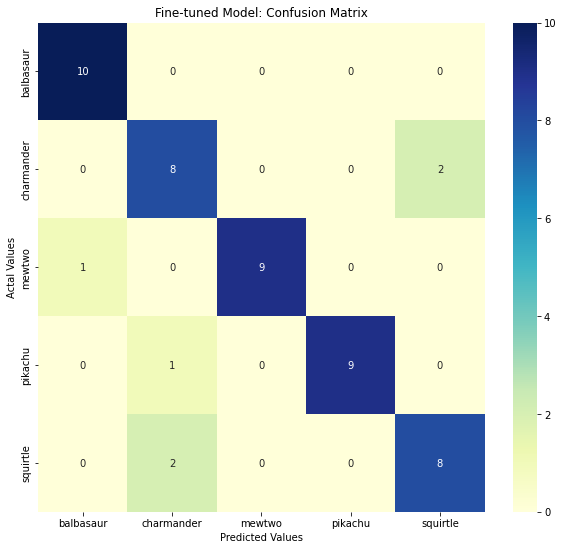

In [35]:
from sklearn.metrics import confusion_matrix


cm_ftune = confusion_matrix(y_test, y_ftune_pred)

print('Confusion matrix: \n',cm_ftune)
print ("\n")

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_ftune_df = pd.DataFrame(cm_ftune,
                     index = classes, 
                     columns = classes)

print ("Confusion Matrix in dataframe form: \n", cm_ftune_df)
print ("\n")

print ("Confusion Matrix in visualised form: \n")
import seaborn as sns
# Plotting the confusion matrix
plt.figure(figsize=(10,9))
sns.heatmap(cm_ftune_df, annot=True, cmap='YlGnBu')
plt.title('Fine-tuned Model: Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


# 7. Perform prediction on fine tuned model
* test image set has already been pre-processed
    * 1. convert to numpy array
    * 2. resized to 224 x 224 x 3 before doing train_test_split
    * 3. normalised after doing train_test_split

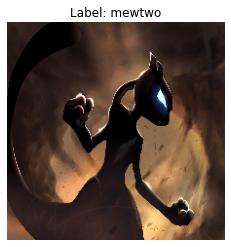

Predicted class: 2 - mewtwo
Probability result of the selected image index  29
balbasaur 	 0.0
charmander 	 0.0
mewtwo    	 1.0
pikachu 	 0.0
squirtle 	 0.0


In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

# Randomly select an image from the test image set (n=50)
imgSize = len(test_images_norm)
# Need to subtract 1 from imgSize because index is only up to 49 for the 50 test images
selected = random.randint(0, imgSize-1)
img_test = test_images_norm[selected]

# To create a mapping of the label class to allow display of the description instead of a number
# Create a list from dictionary keys
categories = list(poke_labels_dict.keys())

# convert image from bgr to rgb
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Label: {}'.format(categories[test_labels[selected][0]]))
plt.show()

# Run the image through the deep neural network (saved best model) to make a prediction
# Add a fourth dimension (since Keras expects a list of images)
img_test = np.expand_dims(img_test, axis=0)
prob = model_finetune_best.predict(img_test)

idx = np.argmax(prob)
predictions = categories[idx]
print('Predicted class: {} - {}'.format(idx, predictions))
# print('Probability: {}\n'.format(prob[0]))

print ('Probability result of the selected image index ', selected) 
for p, name in zip(prob[0], categories):
    if name == 'mewtwo':
        print (name + '   ', '\t', np.round(p,4))
    else:
        print(name, '\t', np.round(p,4))

# 8. Final Evaluation & Conclusion

Overall, we successfully applied transfer learning for the image classification task of 5 pokemons using tensorflow.
The VGG16 neural architecture was used as the base and custom layers such as flatten, dense, dropout and output were added to suit this pokemon image classification task.
As the dataset consists of only 250 images (50 for each pokemon), splitting it into 3 portions for training, validation and testing meant that the data size for training set was relatively small at n=150.
Hence, image augmentation techniques were applied.

Fine-tuning of the model was done and the evaluation metrics reflected significant improvements in the model to correctly classify the pokemon images.
Accuracy score of 72% in base model was improved to 88% in the fine-tuned model.
ROC-AUC score has also improved from 92% to 97%.

Zoning in on the model's performance metrics at individual class labels revealed that the scores for charmander are weakest. This meant that the model is not able to image classify charmander pictures as well as other pokemon. Perhaps we can add more charmander pictures in order to improve the model performance. 

To conclude, the model can be improved by further tuning of the fine-tuned model.
The loss over epochs graph showed some considerable variance between training and validation loss, which was absent in the base model.
One way to go about doing this is to probably add a dropout layer before the flatten layer and after the last max pooling layer in VGG16's block 5 layer.

